# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 13, 
                               #ngram_range=(1, 2), 
                               #token_pattern=r'\b\w+\b', 
                               alternate_sign=False)
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")
    toxic_data['excl_count'] = toxic_data['comment_text'].str.count('!')
    toxic_data['excl_pct'] = toxic_data['excl_count'] / toxic_data['word_count']
    toxic_data['upper_ratio'] = toxic_data['comment_text'].str.count(r'[A-Z]')
    toxic_data['dir_response'] = toxic_data['comment_text'].str.count('you') + toxic_data['comment_text'].str.count('You')
    
    X_quant_features = toxic_data[[#"word_count", 
                                   #punc_count", 
                                   "excl_pct", 
                                   "upper_ratio", 
                                   "dir_response"
                                  ]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [4]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='C:/Users/geoff/PycharmProjects/machine_learning_assignment1/toxic_comments/toxiccomments_train.csv', my_random_seed=19)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [5]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 13048, 'Neg': 114608, 'TP': 6757, 'TN': 49822, 'FP': 64786, 'FN': 6291, 'Accuracy': 0.44321457667481357, 'Precision': 0.0944466963923794, 'Recall': 0.5178571428571429, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [6]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 13048, 'Neg': 114608, 'TP': 10476, 'TN': 113144, 'FP': 1464, 'FN': 2572, 'Accuracy': 0.9683837814125462, 'Precision': 0.8773869346733668, 'Recall': 0.8028816676885346, 'desc': 'svm_train'}


### MODEL: logistic regression

In [7]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 13048, 'Neg': 114608, 'TP': 10738, 'TN': 112552, 'FP': 2056, 'FN': 2310, 'Accuracy': 0.9657987090305196, 'Precision': 0.8392996717211193, 'Recall': 0.822961373390558, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [8]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 13048, 'Neg': 114608, 'TP': 11356, 'TN': 99211, 'FP': 15397, 'FN': 1692, 'Accuracy': 0.8661324183743812, 'Precision': 0.424475759727881, 'Recall': 0.8703249540159411, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [9]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron', alpha=1.0e-5)
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 13048, 'Neg': 114608, 'TP': 10449, 'TN': 112712, 'FP': 1896, 'FN': 2599, 'Accuracy': 0.9647881807357273, 'Precision': 0.846415552855407, 'Recall': 0.8008123850398529, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [10]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=1.0e+4)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 13048, 'Neg': 114608, 'TP': 6822, 'TN': 114274, 'FP': 334, 'FN': 6226, 'Accuracy': 0.9486118944663784, 'Precision': 0.9533258803801006, 'Recall': 0.522838749233599, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [11]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=15, random_state=0, bootstrap=False)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 13048, 'Neg': 114608, 'TP': 434, 'TN': 114608, 'FP': 0, 'FN': 12614, 'Accuracy': 0.9011875665851977, 'Precision': 1.0, 'Recall': 0.033261802575107295, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

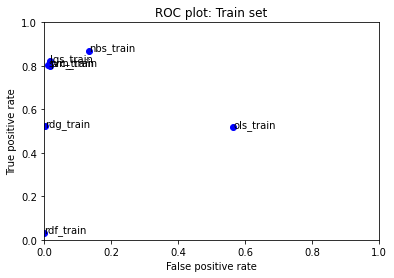

In [12]:
fits = [ols_performance_train, 
        svm_performance_train, 
        lgs_performance_train, 
        nbs_performance_train, 
        prc_performance_train, 
        rdg_performance_train, 
        rdf_performance_train
]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: Train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some false positives:

In [13]:
#FALSE NEGATIVES
ols_predictions = ols.predict(X_train)

In [14]:
# false negatives

print("Examples of false negatives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 0):
        if (X_raw_train.iloc[i]['any_toxic'] == 1):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false negatives:
375
Oh shit, stop sending warning, please, fuck you, Jessie is cancelled and replaced by Rick and Morty.
* * * * * * * * * 
506
KInkaid Stinks 

Kinkaid is a school that not only captures and uses the student as slaves, but also turns thier blood into energy
* * * * * * * * * 
1199
Bold textGREG THOMAS FROM ALBUQUERQUE NEW MEXICO IS GAY
* * * * * * * * * 
2358
antandarus where do you live im sick of you blocking me
* * * * * * * * * 
2454
Thats what yopur mom said last night oooh
* * * * * * * * * 
2516
I mean seriously, who are you? Are you joking? You make a couple of posts saying that the categories do not belong but don't explain why. You got to be kidding me. Your posts make it seem like you are a little kid.
* * * * * * * * * 
2594
Have you fallen on your head as a child? You are pathetic, Jingiby.
* * * * * * * * * 
2768
don't care. Come kill me c'mon!!!!!
* * * * * * * * * 
2868
"

Way to have me be nice to you from the beginning, tell you that you 

16048
because he is a punk hu loves wow he is a big nerdy person
* * * * * * * * * 
17116
Get a life !!! 

what a sad, lonely life you must have where you get a boner by playing Master of Wikipedia, deciding whos edits stay and whos get reverted. My comments were rational and factual but like everything else in life, subjective. Nothing in life is truly objective although you probably disagree, hence your career as a Wikipedia editor. Congratulations on being a bigger loser than I thought possible. You just made me feel better about my sh*tty self!!!
* * * * * * * * * 
17474
Go for it, dipshit.  You're just another islamo/christian terroist.  Fuck off already!  get the fuck out of my coutnry!  Move to fucking Pakistian!
* * * * * * * * * 
17746
"

PUT UP OR SHUT UP
To all you people who think the President is doing such a terrible job. Why don't you run for president and when you get elected try and do it better. It's really easy to play the ""Monday Morning Quarterback"". Its one thin

34048
U BASTARDS STOP BLOCKING ME!
AAAAAAAAAAH
f u all
* * * * * * * * * 
34348
Stop being such a goddamn prick. The article will be sorted out in time. Meanwhile spend some time away from wikipedia. And do normal things. for instance leave your parent's basement.
* * * * * * * * * 
34431
IN THE anus with a nigger dick in it.68.33.41.181
* * * * * * * * * 
34688
stop being a pussbot 

stop being a pussbot. you are extremely biased. Wikipedia cannto tolerate users like you. stop being a shudslavpus
* * * * * * * * * 
35192
Hi 

you're my little b1tsch
* * * * * * * * * 
35367
There seems to be nothing
to check the vileness of the corrupt admin.
* * * * * * * * * 
37137
Blink 182

You ahve 3 Blink 182 CD's???? WOW I have 24 motherfucker.  So I do know what I am talking about.
* * * * * * * * * 
37253
FFS 

You sad little cock muncher.
* * * * * * * * * 
37590
MMM The fact that you have no life but to be on wikipedia makes me horny
* * * * * * * * * 
37885
Well the article i created then 

42638
"

WEEEAHHHH ZOE SO YOU ARE HERE BOB SANTANOS IS A FREAKY MAN!!!

VANDAL ALERT!!!!  VANDAL ALERT!!!!  HAHAHAHEEEAHHHHHHH!!!!!!!!"
* * * * * * * * * 
42906
. I am a stupid whore who sucks dicks all day. I am also transgender and have a penis (so i can fuck myself)
* * * * * * * * * 
43076
SUCK IT!!!!!!!!!!!!!!!!!
HAVE A NICE DAY!!!!!!!!!!
* * * * * * * * * 
43305
LISTEN YA HUMP! QUIT VANDALIZING!!
* * * * * * * * * 
43384
DEAR ASSHOLES

NO IT IS NOT LUCKY I HAVE BEEN BANNED I CONTRIBUTE GREATLY TO WIKIPEDIA AND HELP IT BUT SEVERAL MORONS COME AND WRECK EVERYTHING. UNBLOCK ME, THIS IS UNFAIR AND YOU KNOW IT.
* * * * * * * * * 
43591
, 1 September 2005 (UTC)

p.s.  I think your name is stupid.  That's my POV, and you can cram it in your anus. 05:21
* * * * * * * * * 
43673
!

I won't stop!  LOCK IT UP A$$HOLE
* * * * * * * * * 
44002
Get off my fucking back.. You God-damn little Indian RETARD 

Get off my fucking back.. You God-damn little Indian RETARD. Go and bully around someone 

59847
FUCK YOU DIRTY INDIAN... 

SHYT HEAD INDIAN!!!
* * * * * * * * * 
60341
"

""Ephebophilia"" is from the fucking fourties, DanB. Not ""recent.""  "
* * * * * * * * * 
60421
"

are you insane? YOU DELETE MY USERPAGE WITH THE CLAIM ""VANDALISIM"")"
* * * * * * * * * 
61423
Hello giant asshole,

What the fuck? Feetboarding is extremely popular in St. Louis. You probably wouldn't fucking know cuz u dont live in St. Louis. I do. I think i know a little more about it than you. Who the fuck are you thinking that your hotshit cuz youre the self proclaimed wikipedia police. let people talk about shit that they know about and that you obviously don't know shit about. Thank you cocksucking douschebag.
* * * * * * * * * 
62290
I know. The Matrix would have been a shit film indeed if there were billions of Neos and only one gullible meatsack being used as a human battery. /pwnd
* * * * * * * * * 
62515
Sucker 

Sucking that long di*k of those chicken fuc*ers.
* * * * * * * * * 
62595
this is w

70959
FUCK U DENNIS BURN IN HELL YOU SON OF A BITCH I WILL HURT U
* * * * * * * * * 
70999
Hi 

I Hate you. ^_^
* * * * * * * * * 
71134
Only a NUTCASE liberal could make a statement as ABSURD as has >
* * * * * * * * * 
71335
")
johnboywalton55 says ""you're a spastic!!!""
 also ""Father Daley, reportedly had a big lump on the side of his head in the shape of Connaught."" ("
* * * * * * * * * 
71779
Please Read tHis 

S. dean Jameson called me a pig!  what do I do?
* * * * * * * * * 
72530
stop pimping that shitty gwen gale slut
* * * * * * * * * 
74103
fok yu 2 

YOU OLSOW SUK AS MUZIKANIMUL FOK U
What Shall We Do with the Boo-Hoo BabyWhat Shall We Do with the Boo-Hoo BabyWhat Shall We Do with the Boo-Hoo BabyWhat Shall We Do with the Boo-Hoo BabyWhat Shall We Do with the Boo-Hoo BabyWhat Shall We Do with the Boo-Hoo BabyWhat Shall We Do with the Boo-Hoo BabyWhat Shall We Do with the Boo-Hoo BabyWhat Shall We Do with the Boo-Hoo BabyWhat Shall We Do with the Boo-Hoo BabyWhat Shall We

84136
you're right. allmusic is the last shit.
* * * * * * * * * 
84412
Opinion is opinion and everyone has one of those. You really think all of these aliens were dropped into a volcano based on no evidence, that alien souls are in your body? Fucking idiots. My opinion is more correct than yours
* * * * * * * * * 
84627
your the troll

fine welcome to this encyclopedia - why do you do this? it is hurtful to call anyone a troll specially if they came with a question for judy blume - not a troll!!!

fine keep it then and get herpes!
* * * * * * * * * 
84676
You are a sad git 

Don't you have anything better to be doing? A reclusive millionare pays me ten pounds for every account that I get blocked. HAHAHAHAHAHAHAHA
* * * * * * * * * 
85107
Yeah, all you have to do is stop being such a bitch.
* * * * * * * * * 
85211
I Love vagina and eat pussy everyday.
* * * * * * * * * 
85312
FOCK THEE, LUTHERAN FROM ALLIDA, AKABOR AND LUCIFER, THY LUTHERAN FAITH IS SATANISM
* * * * * * * * * 
85529
u

96600
YOUR HILARIOUS WHY DONT U STOP CHANGING WHAT PPL SAY AND LEAVE THEM ALONE. IF IM CORRECT WERE ALLOWED TO SAY WHATEVER WE FEEL LIKE SO U HAVE NO RIGHT TO CHANGE WHAT OTHER PPL SAY. MAKE A SEPERATE COMMENT ABOUT BUT DONT BE AN A**HOLE AND CHAGE/DELETE IT
* * * * * * * * * 
98364
YOu moron, do not accuse me to go and study. The fools and used like condom people with small or with no brains are YOU! That is also a reason why never Pashtuns can ever establish their fake claims (such as on Ghurids). Because you have no roots to anything. You are not related. Puta Khazana claims are fabricated like the shamefull book self. The bi-sexual Abdul Hai Habibi wanted to copy Shahnama... that´s all behind Pashtun nationalism. New archeological studies led by Dr. Zmarai show the Ghurids beeing non-Pashtuns. Now go and kill Zmarai who spit in the face of Abdul Hai Habibi and clean with Puta Khazana it´s ass.

What has now your valueless and waste comment has to do that Iranians were to the rising

114443
Are you homo?== 

You're acting like a homosexual... Did daddy touch you at night?

==
* * * * * * * * * 
114578
get lost
don't bother me again, you miserable piece of shit!
* * * * * * * * * 
114879
you suck donkey balls fag
* * * * * * * * * 
115169
YOU IDIOT WHY U DELETE MY PAGE!!!
* * * * * * * * * 
115852
Dude you're gay, now seriously STFU and get the fuck off my warning page you little fag.  You've 'warned me' now get the fuck off and act gay somewhere else.
* * * * * * * * * 
115954
You blanked articles to warez groups, dumb ass.  05:23, 17 Jun 2005 (UTC)
* * * * * * * * * 
116385
You know what ID like you to do? LEAVE ME THE FUCK ALONE!!!
* * * * * * * * * 
116514
Admin is a paid scumbag mole and there is NO other answer possible.
* * * * * * * * * 
117243
666 = 2x above Holy 333 Trinity  

repent bastard
* * * * * * * * * 
117717
":::??? In what way is saying ""its useful"" an NPOV issue?? If someone uses this for something, then its useful.  In my case, I am reading a

122485
OH, GET REAL, WILL YA'!! (or, is THAT a totally alien-concept for you??)...

These are not 'angry' - you DO NOT want to see me angry... AGAIN, THESE ARE ALL STATEMENTS OF FACT, WHICH FALLS [SOLIDLY] WITHIN MY 1ST AMMENDMENT RIGHTS. 

Additionally, I DO HAVE MY OWN WEBSITES - SEVERAL OF THEM - AND THERE ARE OTHERS ABOUT ME BUILT BY FANS I'VE NEVER EVEN PHYSICALLY MET... Once more the mark of someone 'wet behind their ears' and not willing to do the research... I GUESS everything that is required of a 'good' editor/administrator, HERE.

I've had this same problem with the 'Wiki' bastards in Australia... Spouting revisionist history, and trying to tell ME that I never did the things that I actually did, and pronouncing 'harsh-judgment'/condemnation on the things I DIDN'T...

What the hell is the matter with you 'types'? (rhetorical, actually)... Because I already know: You hide behind 'avatars' and sit on your 'high-and-mighty-thrones' to try and dictate to other people about THEIR

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [15]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 3177, 'Neg': 28738, 'TP': 1649, 'TN': 12582, 'FP': 16156, 'FN': 1528, 'Accuracy': 0.44590318032273224, 'Precision': 0.09261443414771131, 'Recall': 0.5190431224425559, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [16]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3177, 'Neg': 28738, 'TP': 2099, 'TN': 27756, 'FP': 982, 'FN': 1078, 'Accuracy': 0.9354535484881717, 'Precision': 0.6812723141837066, 'Recall': 0.6606861819326408, 'desc': 'svm_test'}


### MODEL: logistic regression

In [17]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3177, 'Neg': 28738, 'TP': 2151, 'TN': 27591, 'FP': 1147, 'FN': 1026, 'Accuracy': 0.9319128936236879, 'Precision': 0.6522134627046695, 'Recall': 0.6770538243626062, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [18]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3177, 'Neg': 28738, 'TP': 2505, 'TN': 24661, 'FP': 4077, 'FN': 672, 'Accuracy': 0.8511984960050133, 'Precision': 0.3805834092980857, 'Recall': 0.7884796978281398, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [19]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3177, 'Neg': 28738, 'TP': 2093, 'TN': 27601, 'FP': 1137, 'FN': 1084, 'Accuracy': 0.9304088986370045, 'Precision': 0.6479876160990712, 'Recall': 0.6587976078061064, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [20]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3177, 'Neg': 28738, 'TP': 1541, 'TN': 28613, 'FP': 125, 'FN': 1636, 'Accuracy': 0.9448221839260535, 'Precision': 0.924969987995198, 'Recall': 0.48504878816493546, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [21]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 3177, 'Neg': 28738, 'TP': 56, 'TN': 28738, 'FP': 0, 'FN': 3121, 'Accuracy': 0.9022089926366912, 'Precision': 1.0, 'Recall': 0.01762669184765502, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

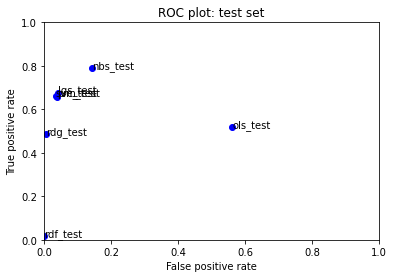

In [22]:
fits = [ols_performance_test, 
        svm_performance_test, 
        lgs_performance_test, 
        nbs_performance_test, 
        prc_performance_test, 
        rdg_performance_test, 
        rdf_performance_test
       ]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [24]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='C:/Users/geoff/PycharmProjects/machine_learning_assignment1/toxic_comments/toxiccomments_test.csv', my_random_seed=19, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 8192)
Look at a few rows of the new quantitative features: 
   excl_pct  upper_ratio  dir_response
0       0.0            4             5
1       0.0            7             0
2       0.0            4             0
3       0.0            4             3
4       0.0            1           

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [25]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = prc.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.1932503721501136


In [26]:
raw_data.head()

,id,comment_text,word_count,punc_count,excl_count,excl_pct,upper_ratio,dir_response
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10,0,0.0,4,5
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1,0,0.0,7,0
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0,0,0.0,4,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3,0,0.0,4,3
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1,0,0.0,1,0


In [27]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,False
2,00013b17ad220c46,False
3,00017563c3f7919a,False
4,00017695ad8997eb,False


In [28]:
my_submission.shape

(153164, 2)

In [29]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('C:/Users/geoff/Desktop/New_School/Semester_5/Machine_Learning/assignment1/iterations/toxiccomments_iter3_gstorr.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation